In [1]:
import os
import re
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import skimage
import anndata as ad
import seaborn as sns
from matplotlib.pyplot import rc_context
from tqdm.notebook import tqdm, trange

sc.settings.verbosity = 3

In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)


In [4]:
import scSpaMet as spamet

In [5]:
experiment = "Lung"
cores = ['B5', 'C6', 'D4', 'E4', 'E6', 'F4']
datasets = [f'{core}_{i}' for core in cores for i in range(1,5)] + ['F7_3', 'F7_4']

In [6]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


# Load data

In [7]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [8]:
%%capture 

adatas = []
adatas_raw = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    # data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    
    # FPM normalize
    sc.pp.normalize_total(adata, target_sum=1e5)
    # sc.pp.log1p(adata, base=2)
    adatas_raw.append(adata.copy())
    
    # Standard scale
    sc.pp.scale(adata)
    adatas.append(adata)
    
adata = ad.concat(adatas, join="inner")
adata_raw = ad.concat(adatas_raw, join="inner")

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished ({time_passed})
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished ({time_passed})
normalizing counts 

In [9]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [10]:
adata = adata[~adata.obs.Dataset.isin(['F7_1', 'F7_2'])]
adata_IMC = adata_IMC_cluster[~adata_IMC_cluster.obs.Dataset.isin(['F7_1', 'F7_2'])]

In [11]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
# mz_qc = df_sum[(df_sum > 16000)].index.tolist()
mz_qc = df_sum[(df_sum > 220)].index.tolist()

In [12]:
len(mz_qc)

197

In [13]:
adata = adata[:, mz_qc]
adata_raw = adata_raw[:, mz_qc]

In [14]:
# Define IMC and SIMS marker list
IMC_markers = adata.var_names.tolist()
SIMS_masses = adata_IMC.var_names.tolist()

# Joint embedding

In [15]:
def Umap(a,rep=None):
    if rep is not None:
        print(f'Using representation {rep}')
        sc.pp.neighbors(a,use_rep=rep)
    else:
        sc.pp.neighbors(a)
    sc.tl.umap(a)
    print('Sucessfully run Umap!')
    return a

In [16]:
train_x_IMC = adata_IMC.X
train_x_SIMS = adata.X

In [17]:
# X_embedding, X_predict = spamet.tl.Joint_VAE(train_x_IMC, epochs=20,  netwidths=[16,8], latent_dim=4)

In [27]:
X_embedding, X_predict, X_predict2 = spamet.tl.Joint_XVAE(train_x_IMC, train_x_SIMS, epochs=100)

GPU name:  []


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/100
610/610 - 2s - loss: 0.5212 - reconstruction_loss: 0.5114 - kl_loss: 0.9856 - 2s/epoch - 4ms/step
Epoch 2/100
610/610 - 1s - loss: 0.4473 - reconstruction_loss: 0.4437 - kl_loss: 0.3615 - 1s/epoch - 2ms/step
Epoch 3/100
610/610 - 1s - loss: 0.4168 - reconstruction_loss: 0.4125 - kl_loss: 0.4338 - 1s/epoch - 2ms/step
Epoch 4/100
610/610 - 1s - loss: 0.3789 - reconstruction_loss: 0.3736 - kl_loss: 0.5272 - 1s/epoch - 2ms/step
Epoch 5/100
610/610 - 1s - loss: 0.3637 - reconstruction_loss: 0.3583 - kl_loss: 0.5429 - 1s/epoch - 2ms/step
Epoch 6/100
610/610 - 1s - loss: 0.3526 - reconstruction_loss: 0.3468 - kl_loss: 0.5849 - 1s/epoch - 2ms/step
Epoch 7/100
610/610 - 1s - loss: 0.3435 - reconstruction_loss: 0.3374 - kl_loss: 0.6094 - 1s/epoch - 2ms/step
Epoch 8/100
610/610 - 1s - loss: 0.3355 - reconstruction_loss: 0.3291 - kl_loss: 0.6382 - 1s/epoch - 2ms/step
Epoch 9/100
610/610 - 1s - loss: 0.3290 - reconstruction_loss: 0.3225 - kl_loss: 0.6527 - 1s/epoch - 2ms/step
Epoch 10/1

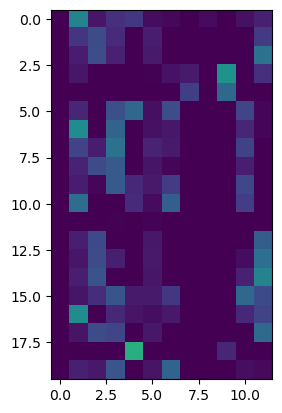

In [23]:
fig, ax = plt.subplots()
im = ax.imshow(train_x_IMC[:20,:], vmin=0, vmax=1)


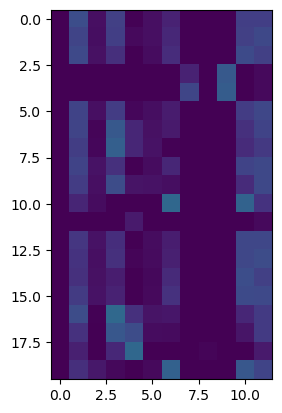

In [24]:
fig, ax = plt.subplots()
im = ax.imshow(X_predict[:20,:], vmin=0, vmax=1)

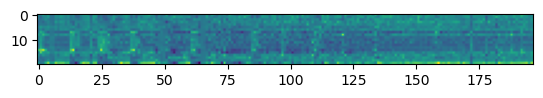

In [26]:
fig, ax = plt.subplots()
im = ax.imshow(train_x_SIMS[:20,:])

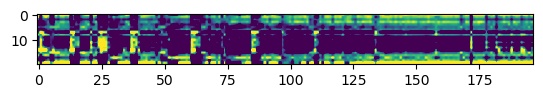

In [28]:
fig, ax = plt.subplots()
im = ax.imshow(X_predict2[:20,:], vmin=0, vmax=1)

In [16]:
adata.obsm['Joint'] = X_embedding

In [17]:
Umap(adata,rep='Joint')

Using representation Joint
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:12)
Sucessfully run Umap!


AnnData object with n_obs × n_vars = 23429 × 211
    obs: 'Cell', 'Dataset', 'Core'
    uns: 'neighbors', 'umap'
    obsm: 'spatial', 'Joint', 'X_umap'
    obsp: 'distances', 'connectivities'

C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


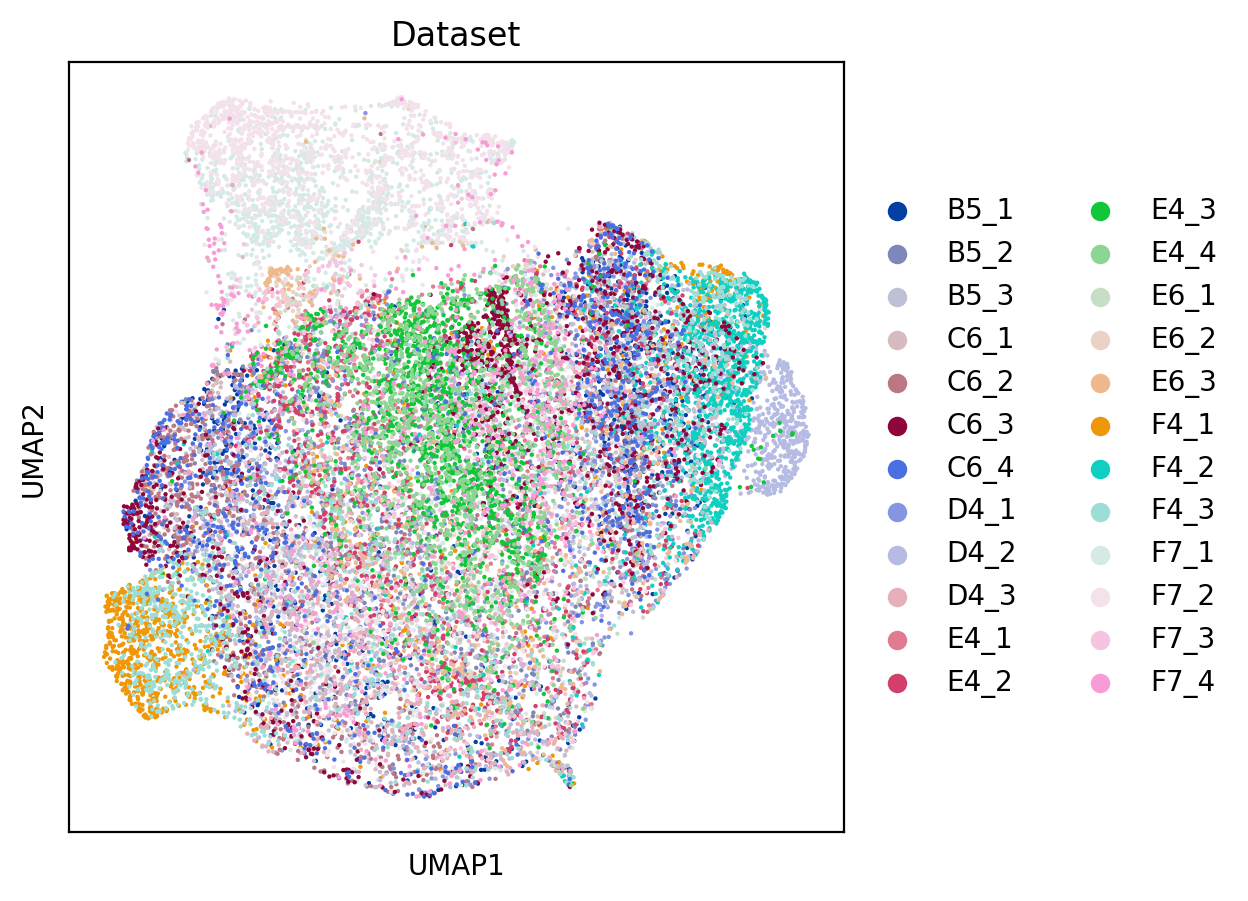

In [18]:

with rc_context({"figure.figsize": (5, 5), "figure.dpi": 200}):
    fig = sc.pl.umap(adata, color=["Dataset"], size=10)

In [19]:
sc.tl.leiden(adata, resolution=0.15, random_state=0)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


# Viz

In [20]:
sc.pp.scale(adata, max_value=4)

In [21]:
adata_IMC = adata[:, IMC_markers]


    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_leiden']`


C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\compat\_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\anndata\_core\anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\thu71\Anaconda3\envs\scspamet\lib\contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
C:\Users\thu71\Anaconda3\envs\scspamet\lib\site-packages\scanpy\plotting\_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sor

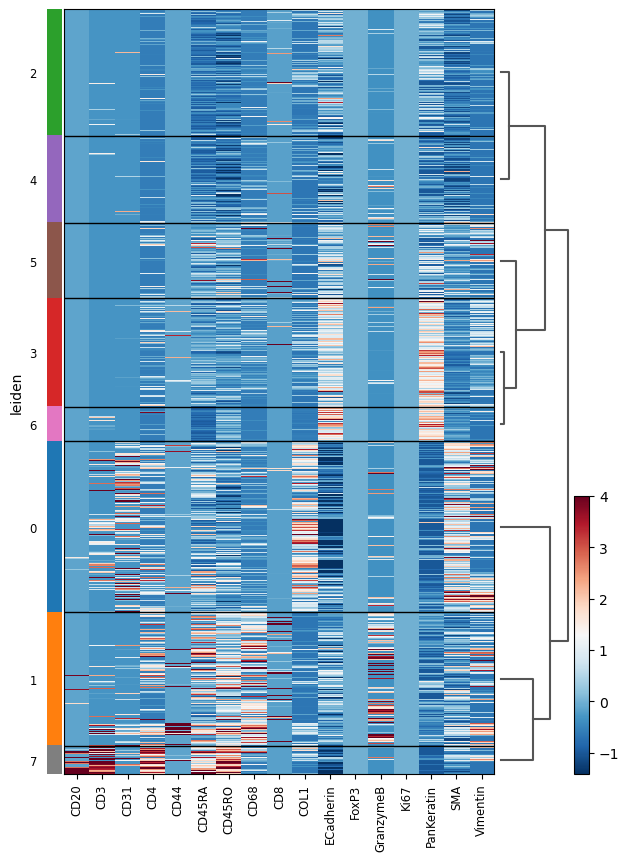

In [22]:
sc.pl.heatmap(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    "leiden",
    dendrogram=True,
    cmap="RdBu_r",
    figsize=(7, 10),
)

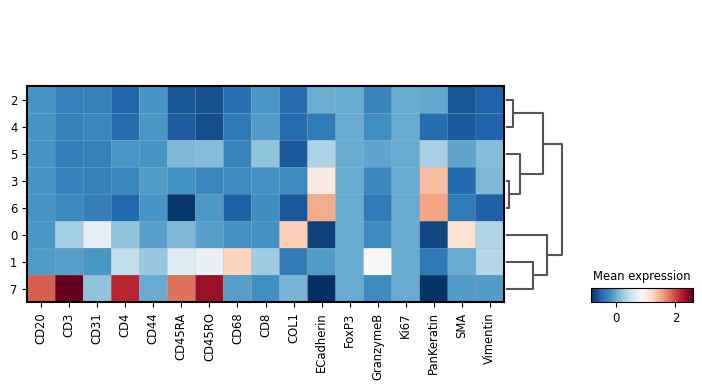

In [23]:
sc.pl.matrixplot(
    adata_IMC,
    adata_IMC.var_names.tolist(),
    "leiden",
    dendrogram=True,
    colorbar_title="Mean expression",
    cmap="RdBu_r",
)

In [24]:
adata_IMC

AnnData object with n_obs × n_vars = 23429 × 17
    obs: 'Cell', 'Dataset', 'Core', 'leiden'
    var: 'mean', 'std'
    uns: 'neighbors', 'umap', 'Dataset_colors', 'leiden', 'leiden_colors', 'dendrogram_leiden'
    obsm: 'spatial', 'Joint', 'X_umap'
    obsp: 'distances', 'connectivities'